In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from xgboost import XGBClassifier
from xgboost import plot_tree as xgb_plot_tree
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import seaborn as sns

# Descrizione problema

Il problema consiste nell'usare la tecnica del sensor fusion per analizzare i dati provenienti da sensori di dverso tipo (temperatura, CO2, ecc.) e rilevare la presenza di un incendio. 

Il dataset è scaricabile a <a href="https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset" target="_blank">questo link</a>

# Esplorazione dei dati

In [2]:
dataset = pd.read_csv('/code/smoke_detection_iot.csv')

In [3]:
dataset.head(3)

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0


Come possiamo vedere dalla tabella qui sopra il dataset presenta le seguenti features:
- `Unnamed: 0`: indice del record
- `UTC`: timestamp del momento in cui è stata eseguita la rilevazione
- `Temperature[C]`: temperatura rilevata in gradi celsius
- `Humidity[%]`: percentuale di umidità dell'aria
- `TVOC[ppb]`: composti organici volatilli (misurati in parti per miliardo)
- `eCO2[ppm]`: concentrazione di CO$_2$
- `Raw H2`: molecole di idrogeno
- `Raw Ethanol`: molecole di etanolo
- `Pressure[hPa]`: pressione dell'aria
- `PM1.0`, `PM2.5`: materiale particolato disperso nell'aria
- `NC0.5`, `NC1.0`, `NC2.5`: concentrazione di particolato
- `CNT`: contatore dei campionamenti
- `Fire Alarm`: presenza o meno di un incendio

Le faeature `Unnamed: 0`, `UTC` e `CNT` non sono significative per l'addestramento di un modello dato che non contengono dati riguardanti misurazioni di sensori, quindi le rimuovo dal dataset. Inoltre rinomino le colonne per avere valori senza caratteri speciali e più semplici da utilizzare.

In [4]:
drop_columns = ['Unnamed: 0', 'UTC', 'CNT']
rename_columns = {
    'Temperature[C]': 'temperature',
    'Humidity[%]': 'humidity',
    'TVOC[ppb]': 'tvoc',
    'eCO2[ppm]': 'co2',
    'Raw H2': 'h2',
    'Raw Ethanol': 'ethanol',
    'Pressure[hPa]': 'pressure',
    'PM1.0': 'pm1',
    'PM2.5': 'pm25',
    'NC0.5': 'nc05',
    'NC1.0': 'nc1',
    'NC2.5': 'nc25',
    'Fire Alarm': 'fire'
}

In [5]:
dataset.drop(drop_columns, axis=1, inplace=True)
dataset.rename(rename_columns, axis=1, inplace=True)

In [6]:
dataset.head(3)

,temperature,humidity,tvoc,co2,h2,ethanol,pressure,pm1,pm25,nc05,nc1,nc25,fire
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0


In [7]:
dataset.describe()

,temperature,humidity,tvoc,co2,h2,ethanol,pressure,pm1,pm25,nc05,nc1,nc25,fire
count,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,0.714626
std,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,0.451596
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,0.000000
50%,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,1.000000
75%,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,1.000000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,1.000000


### Distribuzione delle classi

La distribuzione delle classi è un valore fondamentale da tenere in considerazione durante la classificazione perché se il dataset è troppo sbilanciato, potrebbe essere impossibile generare un modello accurato.

Come possiamo vedere dal grafico sottostante la distribuzione non è ottimale ma è comunque accettabile e , come si potrà vedere successivamente, alcuni modelli performeranno molto bene nonostante questo sbilanciamento.

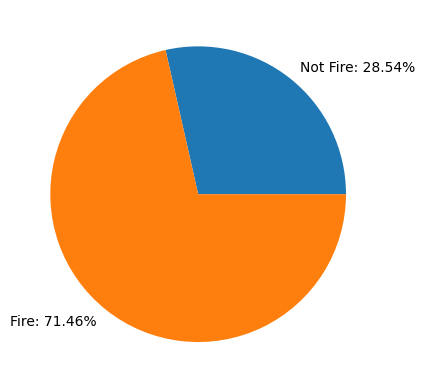

In [8]:
fire_values = dataset['fire'].value_counts()
total_values = fire_values.sum()
plt.pie(x=[fire_values[0], fire_values[1]], labels=['Not Fire: {:.2f}%'.format(fire_values[0] / total_values * 100),
                                                    'Fire: {:.2f}%'.format(fire_values[1]  / total_values * 100)])
plt.show()

### Distribuzione dei valori delle features

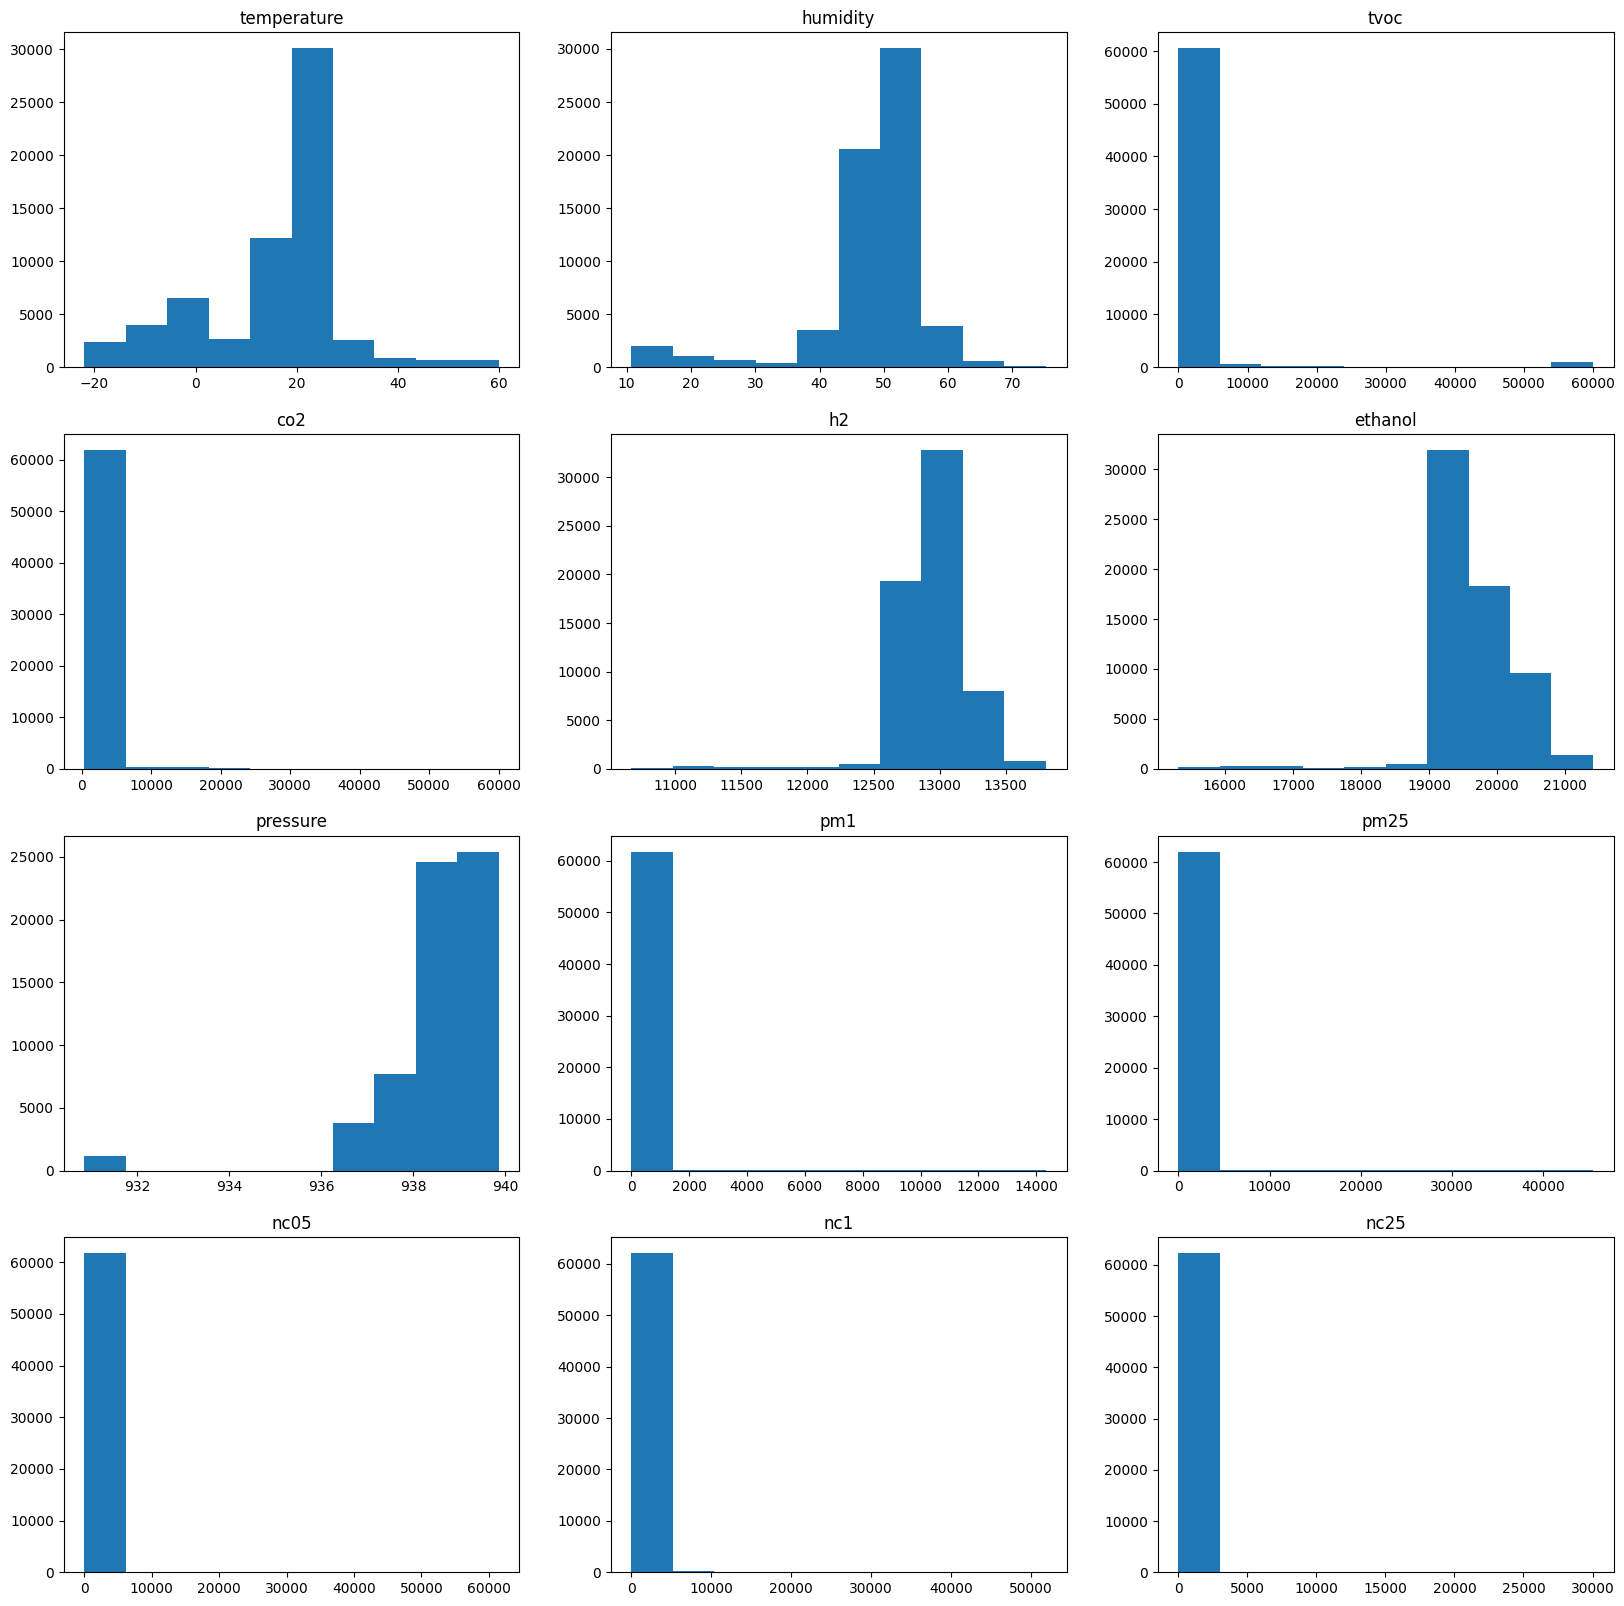

In [9]:
fig, axes = plt.subplots(4, 3)
i = 0
fig.set_size_inches((20, 20))
for col_name in dataset.columns[dataset.columns != 'fire']:
    row = int(i / 3)
    col = i - 3 * row
    values = dataset[col_name].round().value_counts()
    #axes[row, col].hist(values.index, values)
    axes[row, col].hist(dataset[col_name])
    axes[row, col].set_title(col_name)
    i += 1
plt.show()

### Rilevazione valori nulli

Come si può vedere nella cella seguente non sono presenti valori nulli nel dataset, quindi non dobbiamo preoccuparci di come gestirli.

In [10]:
dataset.isna().sum()

temperature    0
humidity       0
tvoc           0
co2            0
h2             0
ethanol        0
pressure       0
pm1            0
pm25           0
nc05           0
nc1            0
nc25           0
fire           0
dtype: int64

# Preparazione dei dati

In questa fase di preparazione dei dati converto i valori dell'umidità da percentuale a un intervallo tra 0 e 1 e poi creo le variabili `X` e `y` che contengono rispettivamente le features e i valori da predire.
Inoltre in questa fase creo l'oggetti `skf`, ovvero quello che definisce in che modo eseguire la k-fold validation, e creo dataset separati per il training e la validazione.

He deciso di non eseguire la standardizzazione dei dati in questa fase perché a seconda del tipo di modello può servire o meno, quindi la eseguirò solo quando necessario.

In [11]:
dataset['humidity'] = dataset['humidity'] / 100
X = dataset.drop(['fire'], axis=1)
y = dataset['fire']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [13]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [14]:
models_scores = {}
best_models = {}

In [15]:
def process_model_scores(test, predictions):
    return {
        'r2': r2_score(test, predictions),
        'mse': mean_squared_error(test, predictions),
        'accuracy': accuracy_score(test, predictions),
        'precision': precision_score(test, predictions),
        'recall': recall_score(test, predictions),
        'f1': f1_score(test, predictions)
    }

def print_model_score(score):
    print('MODEL SCORES:')
    print(f'\tMean Squared Error: {score["mse"]}')
    print(f'\tR2 score: {score["r2"]}')
    print(f'\tAccuracy: {score["accuracy"]}\n')
    print(f'\tPrecision: {score["precision"]}')
    print(f'\tRecall: {score["recall"]}')
    print(f'\tF1 score: {score["f1"]}')

# Modelli di Regressione

I seguenti modello utilizzano tecniche di regressione per la classificazione. Per ciscuno di essi ho creato una pipeline al cui interno ho inserito un oggetto `StandardScaler` che serve per la standardizzazione dei dati. Inoltre, per ottimizzare gli iperparametri, ho eseguito una grid search con cross-validation su tutti i modelli.

## Perceptron

In [16]:
%%time
perceptron_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Perceptron(max_iter=10000, random_state=42, fit_intercept=True))
])

grid = {
    'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'model__l1_ratio': [0.0001, 0.001, 0.01, 0.1]
}
gs = GridSearchCV(perceptron_model, grid, cv=skf)
gs.fit(X_train, y_train)

CPU times: user 40.2 s, sys: 1min 9s, total: 1min 49s
Wall time: 4.98 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        Perceptron(max_iter=10000,
                                                   random_state=42))]),
             param_grid={'model__l1_ratio': [0.0001, 0.001, 0.01, 0.1],
                         'model__penalty': [None, 'l1', 'l2', 'elasticnet']})

In [17]:
gs.best_params_

{'model__l1_ratio': 0.1, 'model__penalty': 'elasticnet'}

In [18]:
models_scores['perceptron'] = process_model_scores(y_test, gs.predict(X_test))
best_models['perceptron'] = gs
print_model_score(models_scores['perceptron'])

MODEL SCORES:
	Mean Squared Error: 0.13300754790013547
	R2 score: 0.3477892853756469
	Accuracy: 0.8669924520998645

	Precision: 0.9711530924198479
	Recall: 0.8387948544346648
	F1 score: 0.900134413484942


## Regressione Logistica

La regressione logistica, come perceptron, necessita della standardizzaione delle features per performare al meglio. Per questo anche in questo caso ho create una pipeline con uno `StandardScaler` che precede il modello vero e proprio.
Anche qui ho utilizzato la grid search con cross validation per l'ottimizzazione degli iperparametri.

In [19]:
%%time
logistic_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=10000, random_state=42, solver='saga', fit_intercept=True))
])

grid = [{
    'model__penalty': ['elasticnet'],
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__l1_ratio': [0.0001, 0.001, 0.01, 0.1]
}, {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__l1_ratio': [None]
}, {
    'model__penalty': ['none']
}]
gs = GridSearchCV(logistic_model, grid, cv=skf, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 11.9 s, sys: 506 ms, total: 12.4 s
Wall time: 1min 10s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.01, 0.1, 1.0, 10.0],
                          'model__l1_ratio': [0.0001, 0.001, 0.01, 0.1],
                          'model__penalty': ['elasticnet']},
                         {'model__C': [0.01, 0.1, 1.0, 10.0],
                          'model__l1_ratio': [None],
                          'model__penalty': ['l1', 'l2']},
                         {'model__penalty': ['none']}])

In [20]:
gs.best_params_

{'model__C': 1.0, 'model__l1_ratio': 0.01, 'model__penalty': 'elasticnet'}

In [21]:
models_scores['logistic_regression'] = process_model_scores(y_test, gs.predict(X_test))
best_models['logistic_regression'] = gs
print_model_score(models_scores['logistic_regression'])

MODEL SCORES:
	Mean Squared Error: 0.10426746661505709
	R2 score: 0.48871804655675477
	Accuracy: 0.8957325333849429

	Precision: 0.908226004789334
	Recall: 0.950101557210562
	F1 score: 0.9286919691605175


# Alberi Decisionali

I seguenti modelli utilizzano alberi decisionali per eseguire la classificazione.

## Decision Tree

Nonostante determinati tipi di alberi decisionali non siano influenzati dalla standardizzazione dei dati, in questo modello ho deciso di utilizzarla ugualmente perché, a seguito di alcuni test, ho notato che l'accuratezza del modello migliora leggermente. Inoltre ho utilizzato la grid search con cross-validation per ottimizzare il valore massimo della profondità dell'albero.

In [22]:
%%time
decision_tree_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier())
])
grid = {
    'model__max_depth': np.arange(5, 21, 1),
}

gs = GridSearchCV(decision_tree_model, grid, cv=skf, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 745 ms, sys: 655 ms, total: 1.4 s
Wall time: 1.07 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])})

In [23]:
gs.best_params_

{'model__max_depth': 13}

In [24]:
models_scores['decision_tree'] = process_model_scores(y_test, gs.predict(X_test))
best_models['decision_tree'] = gs
print_model_score(models_scores['decision_tree'])

MODEL SCORES:
	Mean Squared Error: 0.00019353590090961874
	R2 score: 0.9990509847731912
	Accuracy: 0.9998064640990904

	Precision: 0.9997292540950318
	Recall: 1.0
	F1 score: 0.9998646087191985


## XGBoost

Dato che i risultati sono stati eccellenti fin dall'inizio e credo che sia praticamente impossibile avere un miglioramente significativo, in questo modello ho specificato solamente il parametro che definisce la funzione obiettivo e non ho utilizzato nessun tipo di standardizzazione o di ottimizzazione deli iperparametri.

In [25]:
%%time
xgb_model = XGBClassifier(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

CPU times: user 38.7 s, sys: 965 ms, total: 39.7 s
Wall time: 6.7 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='reg:squarederror',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
models_scores['xgb'] = process_model_scores(y_test, xgb_model.predict(X_test))
best_models['xgb'] = xgb_model
print_model_score(models_scores['xgb'])

MODEL SCORES:
	Mean Squared Error: 9.676795045480937e-05
	R2 score: 0.9995254923865956
	Accuracy: 0.9999032320495452

	Precision: 0.9998646087191985
	Recall: 1.0
	F1 score: 0.9999322997765893


# Reti Neurali

## Multi-layer Perceptron Classifier

In [27]:
%%time
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(solver='adam', activation='relu', max_iter=10000, batch_size=10000))
])
grid = {
    'nn__hidden_layer_sizes': [2, 4, 8, 16, 32, 64, 128]
}
gs = GridSearchCV(mlp_model, grid, n_jobs=-1, cv=skf)
gs.fit(X_train, y_train)

CPU times: user 16min 11s, sys: 21min 33s, total: 37min 45s
Wall time: 2min 23s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn',
                                        MLPClassifier(batch_size=10000,
                                                      max_iter=10000))]),
             n_jobs=-1,
             param_grid={'nn__hidden_layer_sizes': [2, 4, 8, 16, 32, 64, 128]})

In [28]:
gs.best_params_

{'nn__hidden_layer_sizes': 128}

In [29]:
models_scores['mlp'] = process_model_scores(y_test, gs.predict(X_test))
best_models['mlp'] = gs
print_model_score(models_scores['mlp'])

MODEL SCORES:
	Mean Squared Error: 0.00682214050706406
	R2 score: 0.9665472132549895
	Accuracy: 0.9931778594929359

	Precision: 0.994256368673559
	Recall: 0.9962085308056872
	F1 score: 0.9952314924414083


## Keras


### Preprocessing dei dati

Nei modelli precedente che necessitavano della standardizzazione dei dati, questa veniva eseguita direttamente all'interno della pipeline. Utilizzando tensorflow però è più comodo eseguire prima la standardizzazione dei dati e poi addestrare il modello. Inoltre è necessario trasformare la variabile che esplicita la classe in un array dove ogni cella corrisponde ad una classe.

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [31]:
Xt_train = scaler.transform(X_train)
Xt_test = scaler.transform(X_test)

In [32]:
yt_train = to_categorical(y_train)
yt_test = to_categorical(y_test)

In [33]:
yt_train[:3]

array([[0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Creazione Modello

In [34]:
%%time
keras_model = Sequential([
    Dense(8, activation='relu', input_dim=X_train.shape[1]),
    Dense(8, activation='relu'),
    Dense(2, activation='softmax')
])
keras_model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
fit_hist = keras_model.fit(Xt_train, yt_train, batch_size=100, epochs=30)

Epoch 1/30


2022-09-09 19:18:19.638512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:44:00.0, compute capability: 3.7
2022-09-09 19:18:19.639892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10787 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:45:00.0, compute capability: 3.7


420/420 [==============================] - 4s 7ms/step - loss: 0.1336 - accuracy: 0.8307
Epoch 2/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0531 - accuracy: 0.9292
Epoch 3/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0414 - accuracy: 0.9446
Epoch 4/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0354 - accuracy: 0.9527
Epoch 5/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0308 - accuracy: 0.9594
Epoch 6/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0263 - accuracy: 0.9639
Epoch 7/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0225 - accuracy: 0.9709
Epoch 8/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0190 - accuracy: 0.9772
Epoch 9/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0158 - accuracy: 0.9827
Epoch 10/30
420/420 [==============================] - 3s 7ms/step - loss: 0.0134 - accuracy: 0.9857
Epoch 11/3

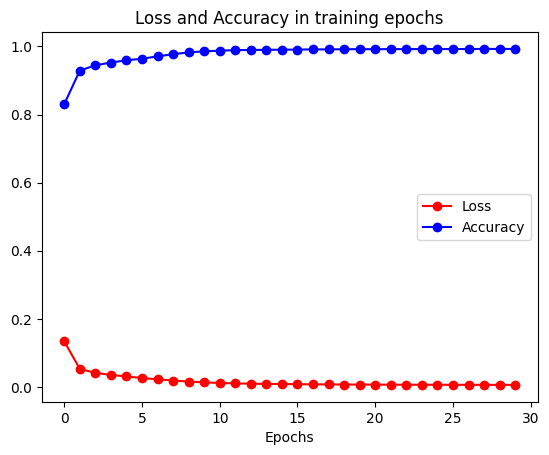

In [35]:
plt.plot(fit_hist.history["loss"], "ro-")
plt.plot(fit_hist.history["accuracy"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.title('Loss and Accuracy in training epochs')
plt.xlabel("Epochs");

In [36]:
keras_model.evaluate(Xt_test, yt_test)

646/646 [==============================] - 3s 5ms/step - loss: 0.0066 - accuracy: 0.9918


[0.006600680761039257, 0.991823136806488]

In [37]:
models_scores['keras'] = process_model_scores(y_test, np.argmax(keras_model.predict(Xt_test).round(),
                                                                axis=1))
best_models['keras'] = keras_model
print_model_score(models_scores['keras'])

646/646 [==============================] - 2s 3ms/step
MODEL SCORES:
	Mean Squared Error: 0.008176891813431392
	R2 score: 0.9599041066673278
	Accuracy: 0.9918231081865686

	Precision: 0.9916492693110647
	Recall: 0.9969532836831415
	F1 score: 0.9942942030453426


# Comparazione Modelli

## Analisi Score

In [38]:
scores_df = pd.DataFrame.from_dict(models_scores)

In [39]:
scores_df

,perceptron,logistic_regression,decision_tree,xgb,mlp,keras
r2,0.347789,0.488718,0.999051,0.999525,0.966547,0.959904
mse,0.133008,0.104267,0.000194,0.000097,0.006822,0.008177
accuracy,0.866992,0.895733,0.999806,0.999903,0.993178,0.991823
precision,0.971153,0.908226,0.999729,0.999865,0.994256,0.991649
recall,0.838795,0.950102,1.000000,1.000000,0.996209,0.996953
f1,0.900134,0.928692,0.999865,0.999932,0.995231,0.994294


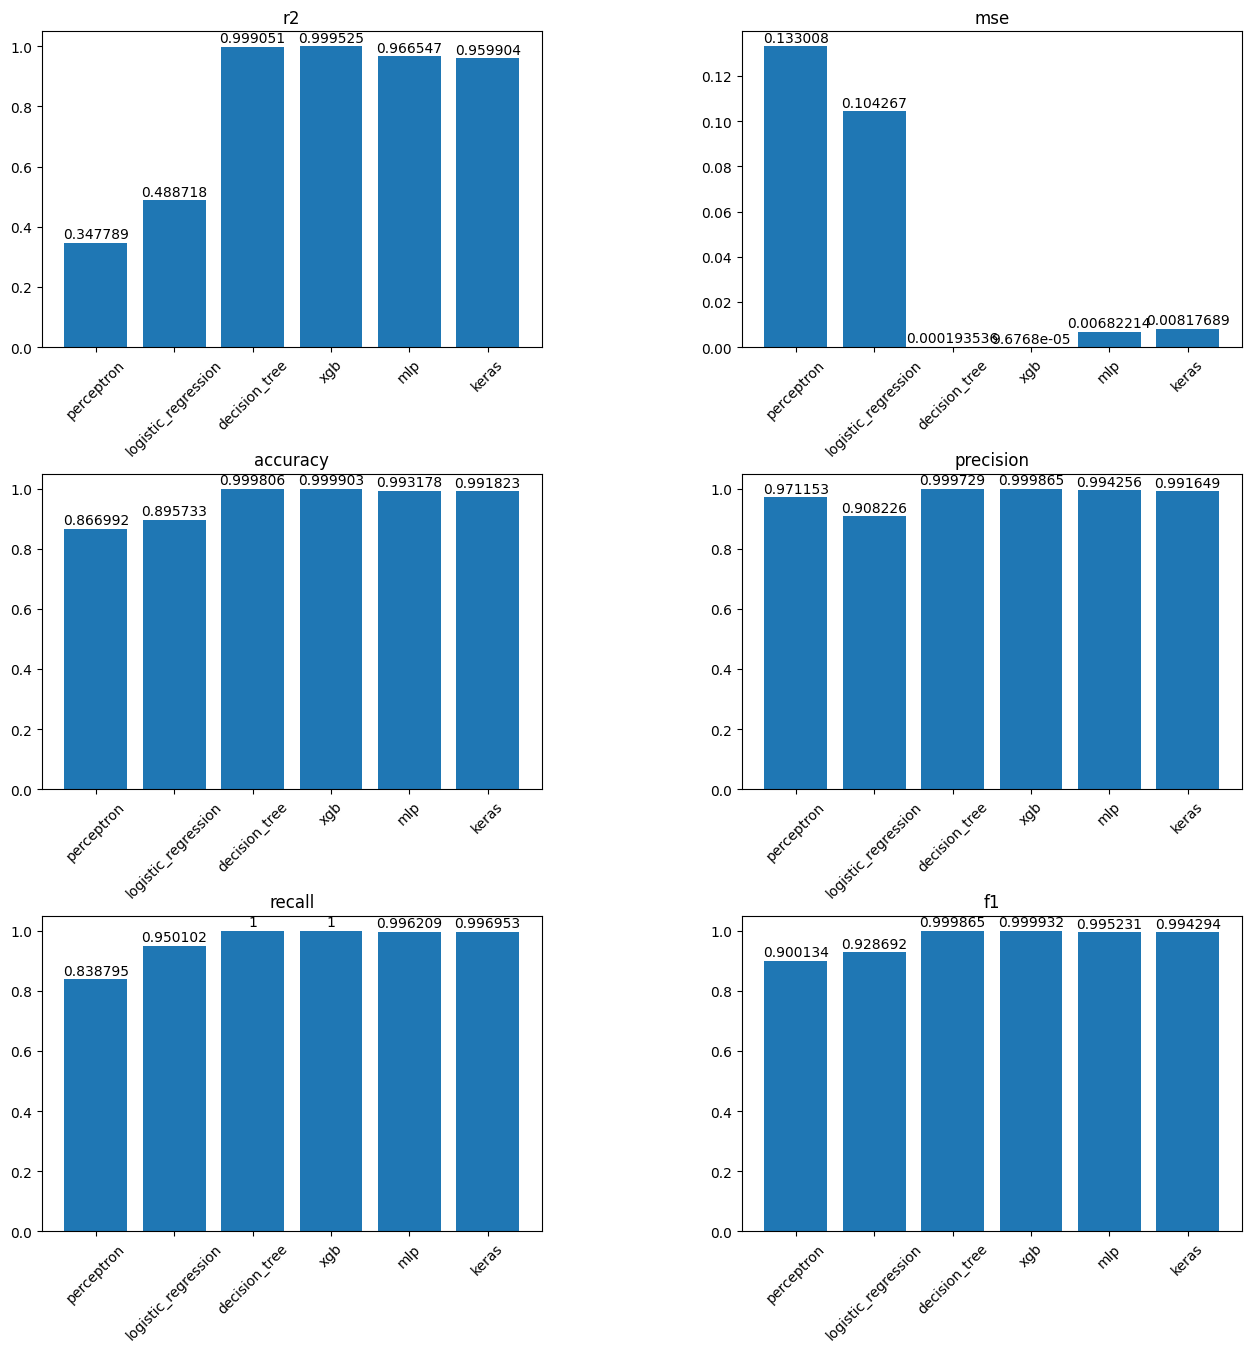

In [53]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches((15, 15))
i = 0
for c in scores_df.index:
    row = int(i / 2)
    col = i - 2 * row
    rect = ax[row, col].bar(scores_df.columns, scores_df.loc[c])
    for l in ax[row, col].get_xticklabels():
        l.set_rotation(45)
    ax[row, col].set_title(c)
    ax[row, col].bar_label(rect, padding=1)
    i += 1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Analisi Risultati

Come si puù vedere dai grafici sopra, i modelli con gli score migliori sono quelli basati su alberi decisionali (xgboost e decision tree). Anche i modelli basati su reti neurali hanno dato risultati ottimi mentre invece quelli basati su regressione sono leggermente inferiori (in ogni caso si parla di ottimi score con un'accuratezza superiore a 80%).

In [70]:
# refit modello decision_tree
dt_model = best_models['decision_tree'].best_estimator_
dt_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(max_depth=13))])

In [59]:
xgb_model = best_models['xgb']

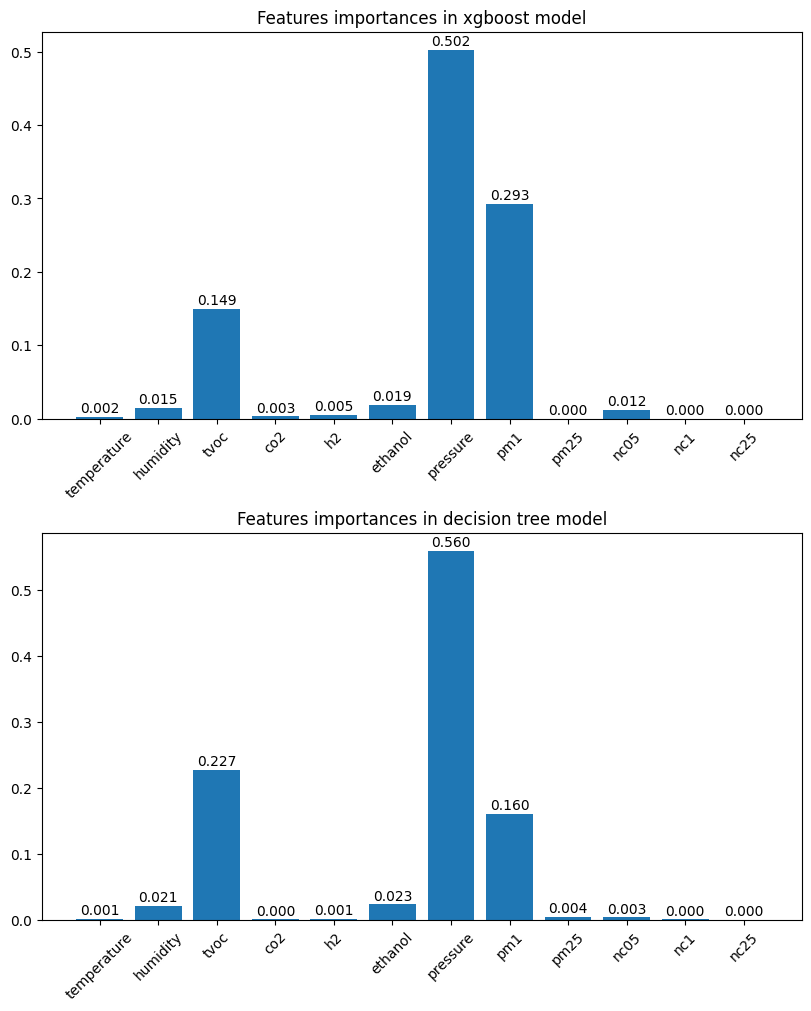

In [112]:
labels = X_train.columns
fig, ax = plt.subplots(2, constrained_layout = True)
fig.set_size_inches((8,10))
# xgb chart
rects = ax[0].bar(labels, xgb_model.feature_importances_)
for l in ax[0].get_xticklabels():
    l.set_rotation(45)
ax[0].bar_label(rects, labels=['{:.3f}'.format(i) for i in xgb_model.feature_importances_], padding=1)
ax[0].set_title('Features importances in xgboost model')
# decision tree chart
rects = ax[1].bar(labels, dt_model[1].feature_importances_)
for l in ax[1].get_xticklabels():
    l.set_rotation(45)
ax[1].bar_label(rects, labels=['{:.3f}'.format(i) for i in dt_model[1].feature_importances_], padding=1)
ax[1].set_title('Features importances in decision tree model')
plt.show()

Come si può vedere dai grafici sopra, nonostante alcune piccole differenze, le features più significative sono le stesse sia nel modello che utilizza xgboost che in quello che utilizza decision tree.